In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from SimCLR_data_util import preprocess_for_train
from resnet_small import ResNet18
from tensorflow.keras.layers import Dense
from viewmaker import *
from SimCLR import *

In [2]:
tf.__version__

'2.6.0'

In [3]:
from datasets.cifar_10 import get_unsupervised_dataset
dataset = get_unsupervised_dataset(batch_size=64)

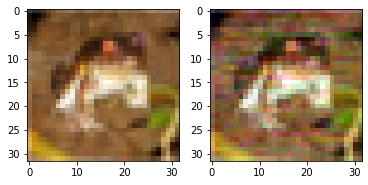

In [4]:
batch = next(iter(dataset))
viewmaker = Viewmaker()
batch_augmented = viewmaker(batch)
fix, (axis1, axis2) = plt.subplots(1, 2)
axis1.imshow(batch[0])
axis2.imshow(batch_augmented[0])

In [5]:
viewmaker.output_shape

AttributeError: The layer has never been called and thus has no defined output shape.

In [7]:
def get_encoder():
    model = ResNet18(10)
    encoder = tf.keras.Sequential(model.layers[:-1])
    # encoder = tf.keras.Sequential([
    #     encoder, 
    #     tf.keras.layers.ReLU(), 
    #     tf.keras.layers.Dense(2048)
    # ])
    return encoder

encoder = get_encoder()

In [8]:
batch = next(iter(dataset))
output = encoder(batch)
encoder.summary()
print(f'input shape: {batch.shape}')
print(f'output shape: {output.shape}')

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (64, 32, 32, 64)          1728      
_________________________________________________________________
batch_normalization_20 (Batc (64, 32, 32, 64)          256       
_________________________________________________________________
sequential_15 (Sequential)   (64, 32, 32, 64)          148480    
_________________________________________________________________
sequential_18 (Sequential)   (64, 16, 16, 128)         526848    
_________________________________________________________________
sequential_21 (Sequential)   (64, 8, 8, 256)           2102272   
_________________________________________________________________
sequential_24 (Sequential)   (64, 4, 4, 512)           8398848   
_________________________________________________________________
flatten_1 (Flatten)          (64, 8192)              

In [10]:
batch = next(iter(dataset))
viewmaker = Viewmaker()
output = viewmaker(batch)
viewmaker.summary()
print(f'input shape: {batch.shape}')
print(f'output shape: {output.shape}')

Model: "viewmaker_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
re_lu_28 (ReLU)              multiple                  0         
_________________________________________________________________
conv_layer_28 (ConvLayer)    multiple                  10400     
_________________________________________________________________
instance_normalization_30 (I multiple                  64        
_________________________________________________________________
conv_layer_29 (ConvLayer)    multiple                  18496     
_________________________________________________________________
instance_normalization_31 (I multiple                  128       
_________________________________________________________________
conv_layer_30 (ConvLayer)    multiple                  73856     
_________________________________________________________________
instance_normalization_32 (I multiple                  

In [11]:
def get_projection_head():

    projection_head = tf.keras.Sequential([
        Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        Dense(256)
    ])

    return projection_head

projection_head = get_projection_head()

In [12]:
model = SimCLR_adversarial(encoder, viewmaker, projection_head)

In [14]:
BATCH_SIZE = 128 
EPOCHS = 100     
LEARNING_RATE = 0.0001
SAVE_DIRECTORY = './cifar_10_experiment'

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))

dataset = get_unsupervised_dataset(batch_size=BATCH_SIZE)  
dataset = dataset.take(len(dataset)-1)

model.fit(dataset, epochs=EPOCHS)

Epoch 1/100
468/468 [==============================] - 182s 361ms/step - SimCLR loss: 4.6252 - SimCLR accuracy: 0.9893
Epoch 2/100
468/468 [==============================] - 167s 357ms/step - SimCLR loss: 4.6211 - SimCLR accuracy: 0.9877
Epoch 3/100
468/468 [==============================] - 165s 353ms/step - SimCLR loss: 4.6094 - SimCLR accuracy: 0.9944
Epoch 4/100
468/468 [==============================] - 169s 362ms/step - SimCLR loss: 4.6178 - SimCLR accuracy: 0.9867
Epoch 5/100
468/468 [==============================] - 165s 352ms/step - SimCLR loss: 4.6278 - SimCLR accuracy: 0.9712
Epoch 6/100
468/468 [==============================] - 161s 343ms/step - SimCLR loss: 4.6298 - SimCLR accuracy: 0.9692
Epoch 7/100
468/468 [==============================] - 161s 343ms/step - SimCLR loss: 4.6362 - SimCLR accuracy: 0.9608
Epoch 8/100
468/468 [==============================] - 161s 343ms/step - SimCLR loss: 4.6379 - SimCLR accuracy: 0.9629
Epoch 9/100
468/468 [===========================

In [23]:
model.layers[0].layers[5].summary()


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
basic_block_6 (BasicBlock)   (None, 4, 4, 512)         3676160   
_________________________________________________________________
basic_block_7 (BasicBlock)   (None, 4, 4, 512)         4722688   
Total params: 8,398,848
Trainable params: 8,393,728
Non-trainable params: 5,120
_________________________________________________________________


In [15]:
model.save_weights(f'{SAVE_DIRECTORY}/viewmaker_and_simclr_weights/ckpt1')